In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
pd.set_option('display.max_columns', 500)
import sys, os
from sklearn.kernel_approximation import Nystroem
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

In [2]:
from derm7pt.dataset import Derm7PtDataset, Derm7PtDatasetGroupInfrequent
from derm7pt.vis import plot_confusion
from derm7pt.kerasutils import deep_features

Using TensorFlow backend.


In [3]:
# CHANGE THIS LINE TO YOUR DATA DIRECTORY.
dir_release = '../'
dir_meta = os.path.join(dir_release, 'meta')
dir_images = os.path.join(dir_release, 'images')

In [4]:
meta_df = pd.read_csv(os.path.join(dir_meta, 'meta.csv'))
train_indexes = list(pd.read_csv(os.path.join(dir_meta, 'train_indexes.csv'))['indexes'])
valid_indexes = list(pd.read_csv(os.path.join(dir_meta, 'valid_indexes.csv'))['indexes'])
test_indexes = list(pd.read_csv(os.path.join(dir_meta, 'test_indexes.csv'))['indexes'])

In [5]:
# The full dataset before any grouping of the labels.
derm_data = Derm7PtDataset(dir_images=dir_images, 
                        metadata_df=meta_df.copy(),
                        train_indexes=train_indexes, valid_indexes=valid_indexes, 
                        test_indexes=test_indexes)

# The dataset after grouping infrequent labels.
derm_data_group = Derm7PtDatasetGroupInfrequent(dir_images=dir_images, 
                                             metadata_df=meta_df.copy(),
                                             train_indexes=train_indexes, 
                                             valid_indexes=valid_indexes, 
                                             test_indexes=test_indexes)

In [6]:
derm_data.dataset_stats()

Number of cases: 1011
Number of cases to train: 413
Number of cases to validate: 203
Number of cases to test: 395


In [7]:
# Converted the meta-data to categorical (*_numeric) labels.
derm_data_group.df.head()

,case_num,diagnosis,seven_point_score,pigment_network,streaks,pigmentation,regression_structures,dots_and_globules,blue_whitish_veil,vascular_structures,level_of_diagnostic_difficulty,elevation,location,sex,management,clinic,derm,case_id,notes,diagnosis_numeric,pigment_network_numeric,blue_whitish_veil_numeric,vascular_structures_numeric,pigmentation_numeric,streaks_numeric,dots_and_globules_numeric,regression_structures_numeric
0,1,basal cell carcinoma,0,absent,absent,absent,absent,absent,absent,arborizing,medium,nodular,abdomen,female,excision,NEL/NEL025.JPG,NEL/Nel026.jpg,NaN,NaN,0,0,0,1,0,0,0,0
1,2,basal cell carcinoma,1,absent,absent,absent,absent,irregular,absent,absent,low,palpable,head neck,female,excision,NEL/NEL027.JPG,NEL/Nel028.jpg,NaN,NaN,0,0,0,0,0,0,2,0
2,3,basal cell carcinoma,1,absent,absent,absent,absent,irregular,absent,arborizing,medium,palpable,head neck,female,excision,NEL/Nel032.jpg,NEL/Nel033.jpg,NaN,NaN,0,0,0,1,0,0,2,0
3,4,basal cell carcinoma,4,absent,absent,absent,blue areas,irregular,present,within regression,low,palpable,lower limbs,male,excision,NEL/NEL034.JPG,NEL/Nel035.jpg,NaN,NaN,0,0,1,1,0,0,2,1
4,5,basal cell carcinoma,1,absent,absent,diffuse irregular,absent,absent,absent,absent,high,palpable,upper limbs,female,excision,NEL/NEL036.JPG,NEL/Nel037.jpg,NaN,NaN,0,0,0,0,2,0,0,0


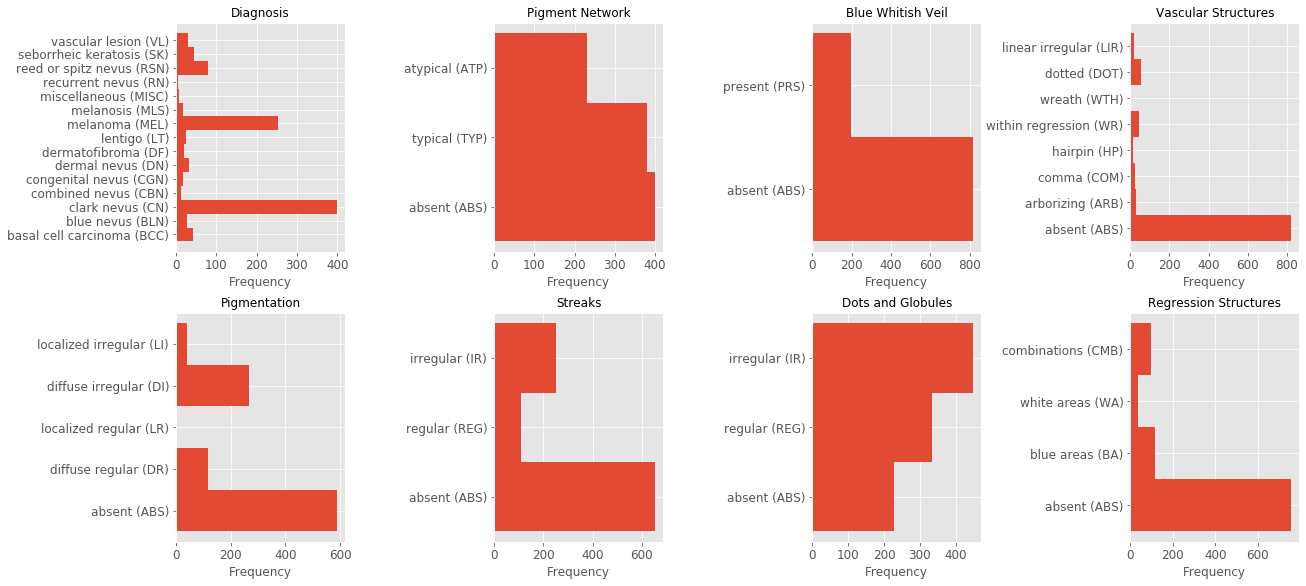

In [8]:
# Distribution of the labels before any grouping (most granular labels).
derm_data.plot_tags_hist(figsize=(18,8), fontsize=12)

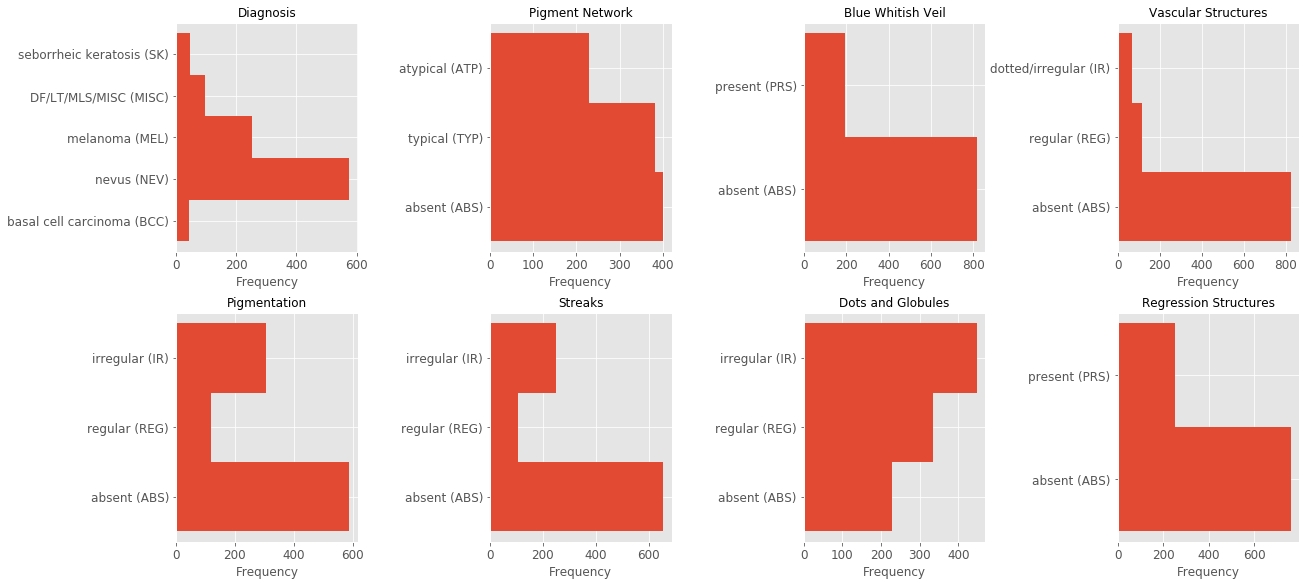

In [9]:
# Distribution of the labels after the grouping.
# We group some clinicially labels as many granular labels occur very infrequently.
derm_data_group.plot_tags_hist(figsize=(18,8), fontsize=12)

case_num                                             4
diagnosis                         basal cell carcinoma
seven_point_score                                    4
pigment_network                                 absent
streaks                                         absent
pigmentation                                    absent
regression_structures                       blue areas
dots_and_globules                            irregular
blue_whitish_veil                              present
vascular_structures                  within regression
level_of_diagnostic_difficulty                     low
elevation                                     palpable
location                                   lower limbs
sex                                               male
management                                    excision
clinic                                  NEL/NEL034.JPG
derm                                    NEL/Nel035.jpg
case_id                                            NaN
notes     

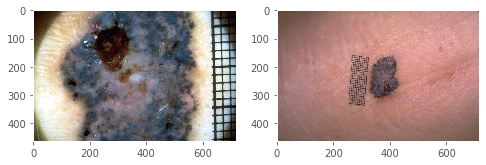

In [10]:
# Show the derm and clinical image for a single case.
row_index = 3
derm = derm_data_group.derm_image(row_index=row_index)
clinic = derm_data_group.clinic_image(row_index=row_index)
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(derm)
plt.grid(False)
plt.subplot(1,2,2)
plt.imshow(clinic)
plt.grid(False)
# Show the corresponding info.
print(derm_data_group.df.iloc[row_index])

<h1>Example using Deep Features and a Linear Model</h1>

In [11]:
# Get the dermatology and clinic training images and corresponding labels.
train_derm_paths = derm_data_group.get_img_paths(data_type='train', img_type='derm')
train_clinic_paths = derm_data_group.get_img_paths(data_type='train', img_type='clinic')
train_labels = derm_data_group.get_labels(data_type='train', one_hot=False)

# The 8 abbreviations that indicate the different types of categories 
# i.e., 1 diagnosis + 7 critiera.
print(train_labels.keys())

dict_keys(['DIAG', 'PN', 'BWV', 'VS', 'PIG', 'STR', 'DaG', 'RS'])


In [12]:
# Get the dermatology and clinic test images and corresponding labels.
test_derm_paths = derm_data_group.get_img_paths(data_type='test', img_type='derm')
test_clinic_paths = derm_data_group.get_img_paths(data_type='test', img_type='clinic')
test_labels = derm_data_group.get_labels(data_type='test', one_hot=False)

In [13]:
# Get the dermatology and clinic validation images and corresponding labels.
valid_derm_paths = derm_data_group.get_img_paths(data_type='valid', img_type='derm')
valid_clinic_paths = derm_data_group.get_img_paths(data_type='valid', img_type='clinic')
valid_labels = derm_data_group.get_labels(data_type='valid', one_hot=False)
print(len(valid_derm_paths))

203


In [14]:
# Choose a pretrained model to extract features from.
from efficientnet.keras import EfficientNetB7, preprocess_input
input_shape = (224, 224, 3)
model = EfficientNetB7(include_top = False, weights='imagenet',input_shape=input_shape)

In [15]:
# Apply cropping around the boundary of the images to get rid of the black boundary.
crop_amount= 25

<h2>Extract features from dermatology images</h2>

In [16]:
# Extract features from training images (might take a few minutes... ideally you have a GPU.)
train_derm_f = deep_features(img_paths=train_derm_paths, model=model, 
                             func_preprocess_input=preprocess_input, 
                             target_size=input_shape, crop_amount=crop_amount)

In [17]:
# Extract features from validating images (might take a few minutes... ideally you have a GPU.)
valid_derm_f = deep_features(img_paths=valid_derm_paths, model=model, 
                             func_preprocess_input=preprocess_input, 
                             target_size=input_shape, crop_amount=crop_amount)

In [18]:
# Extract features from testing images (might take a few minutes)
test_derm_f = deep_features(img_paths=test_derm_paths, model=model, 
                            func_preprocess_input=preprocess_input, 
                            target_size=input_shape, crop_amount=crop_amount)

In [19]:
# Number_of_images x number_of_features 
print(train_derm_f.shape)
print(valid_derm_f.shape)
print(test_derm_f.shape)

(413, 2560)
(203, 2560)
(395, 2560)


<h2>Extract features from clinical images</h2>

In [20]:
# Same for clinical images
train_clinic_f = deep_features(img_paths=train_clinic_paths, model=model, 
                               func_preprocess_input=preprocess_input, 
                               target_size=input_shape, crop_amount=crop_amount)

valid_clinic_f = deep_features(img_paths=valid_clinic_paths, model=model, 
                               func_preprocess_input=preprocess_input, 
                               target_size=input_shape, crop_amount=crop_amount)

test_clinic_f = deep_features(img_paths=test_clinic_paths, model=model, 
                              func_preprocess_input=preprocess_input, 
                              target_size=input_shape, crop_amount=crop_amount)
print(train_clinic_f.shape)
print(valid_clinic_f.shape)
print(test_clinic_f.shape)

(413, 2560)
(203, 2560)
(395, 2560)


<h2>Train a Classifier models on the images</h2>

In [21]:
#importing of the libraries of classifiers
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import numpy as np
#getting the diagnotsics of each input
abbrev = 'DIAG'
# These are the labels associated with the given abbreviation.
label_names = derm_data_group.get_label_by_abbrev(abbrev).abbrevs.values

In [22]:
# Random Forest Classifier
reg = RandomForestClassifier(n_estimators = 51,criterion='gini',min_samples_split=0.1,max_depth=25)
reg.fit(train_derm_f, train_labels[abbrev])
reg.fit(valid_derm_f, valid_labels[abbrev])  
# cross validation.
scores_t = cross_val_score(reg, train_derm_f, train_labels[abbrev], cv=5, scoring='accuracy')
scores_l = cross_val_score(reg, valid_derm_f, valid_labels[abbrev], cv=5, scoring='accuracy')
#prediciton
t1 = scores_t.mean()
t2 = scores_l.mean()
scores = (t1+t2)/2
pred = reg.predict(test_derm_f)
temp = accuracy_score(test_labels[abbrev],pred)

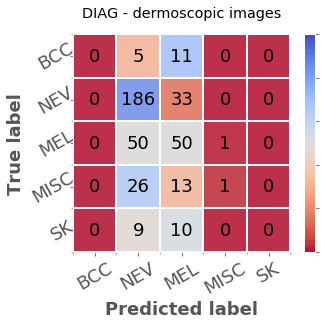

Accuracy Score: 60.0 %
Cross-Validation Score: 60.531516309139 %


In [23]:
# Display a confusion matrix.
plot_confusion(y_true=test_labels[abbrev], y_pred=pred, labels=label_names, figsize=(6,4))
plt.title(abbrev + ' - dermoscopic images')
plt.show()
print("Accuracy Score:",temp*100,"%")
print("Cross-Validation Score:",scores*100,"%")

In [69]:
#Nerual Network Classifier
reg = MLPClassifier(hidden_layer_sizes=(125,256,512 ), activation='relu', solver='adam', alpha=0.1,max_iter = 500)
reg.fit(train_derm_f, train_labels[abbrev])
reg.fit(valid_derm_f, valid_labels[abbrev])
# cross validation.
scores_t = cross_val_score(reg, train_derm_f, train_labels[abbrev], cv=5, scoring='accuracy')
scores_l = cross_val_score(reg, valid_derm_f, valid_labels[abbrev], cv=5, scoring='accuracy')
t1 = scores_t.mean()
t2 = scores_l.mean()
score = (t1+t2)/2

#prediciton
pred = reg.predict(test_derm_f)
temp = accuracy_score(test_labels[abbrev],pred)

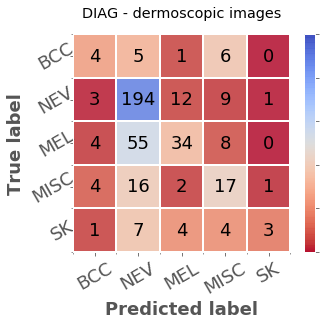

Accuracy Score: 63.79746835443038 %
Cross-Validation Score: 59.01241551572143 %


In [70]:
# Display a confusion matrix.
plot_confusion(y_true=test_labels[abbrev], y_pred=pred, labels=label_names, figsize=(6,4))
plt.title(abbrev + ' - dermoscopic images')
plt.show()
print("Accuracy Score:",temp*100,"%")
print("Cross-Validation Score:",score*100,"%")

In [111]:
#Decision Tree Classifier
reg = DecisionTreeClassifier(max_depth=2)
reg.fit(train_derm_f, train_labels[abbrev])
reg.fit(valid_derm_f, valid_labels[abbrev])
# Cross-Validation
scores_t = cross_val_score(reg, train_derm_f, train_labels[abbrev], cv=5, scoring='accuracy')
scores_l= cross_val_score(reg, valid_derm_f, valid_labels[abbrev], cv=5, scoring='accuracy')
t1 = scores_t.mean()
t2 = scores_l.mean()
score = (t1+t2)/2
# Predictions
pred = reg.predict(test_derm_f)
temp = accuracy_score(test_labels[abbrev],pred)

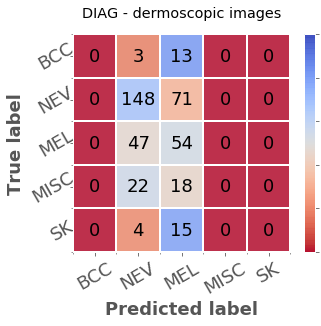

Accuracy Score: 51.13924050632911 %
Cross-Validation Score: 52.83279459300617 %


In [112]:
# Display a confusion matrix.
plot_confusion(y_true=test_labels[abbrev], y_pred=pred, labels=label_names, figsize=(6,4))
plt.title(abbrev + ' - dermoscopic images')
plt.show()
print("Accuracy Score:",temp*100,"%")
print("Cross-Validation Score:",score*100,"%")

In [97]:
# Adaptive Boosting Classifier
reg = AdaBoostClassifier(n_estimators = 20)
reg.fit(train_derm_f, train_labels[abbrev])
reg.fit(valid_derm_f, valid_labels[abbrev])  
# cross validation.
scores_t = cross_val_score(reg, train_derm_f, train_labels[abbrev], cv=5, scoring='accuracy')
scores_l = cross_val_score(reg, valid_derm_f, valid_labels[abbrev], cv=5, scoring='accuracy')
t1 = scores_t.mean()
t2 = scores_l.mean()
score =(t1+t2)/2
#prediciton
pred = reg.predict(test_derm_f)
temp = accuracy_score(test_labels[abbrev],pred)

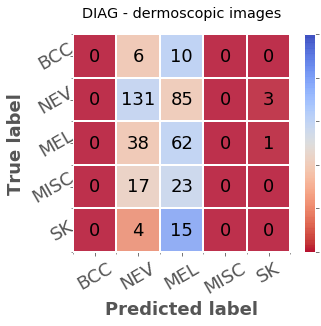

Accuracy Score: 48.860759493670884 %
Cross-Validation Score: 50.51212165736114 %


In [98]:
# Display a confusion matrix.
plot_confusion(y_true=test_labels[abbrev], y_pred=pred, labels=label_names, figsize=(6,4))
plt.title(abbrev + ' - dermoscopic images')
plt.show()
print("Accuracy Score:",temp*100,"%")
print("Cross-Validation Score:",score*100,"%")

In [53]:
# K- Nearest Neighbors Classifier
reg = KNeighborsClassifier(n_neighbors = 15)
reg.fit(train_derm_f, train_labels[abbrev])
reg.fit(valid_derm_f, valid_labels[abbrev])  
# cross validation.
scores_t = cross_val_score(reg, train_derm_f, train_labels[abbrev], cv=5, scoring='accuracy')
scores_l = cross_val_score(reg, valid_derm_f, valid_labels[abbrev], cv=5, scoring='accuracy')
t1 = scores_t.mean()
t2 = scores_l.mean()
score = (t1+t2)/2

#prediciton
pred = reg.predict(test_derm_f)
temp = accuracy_score(test_labels[abbrev],pred)

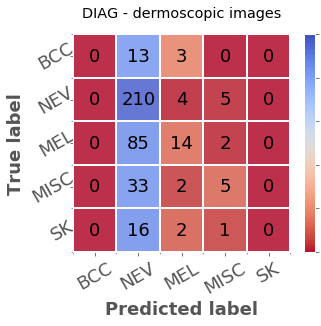

Accuracy Score: 57.974683544303794 %
Cross-Validation Score: 57.467602115780196 %


In [55]:
# Display a confusion matrix.
plot_confusion(y_true=test_labels[abbrev], y_pred=pred, labels=label_names, figsize=(6,4))
plt.title(abbrev + ' - dermoscopic images')
plt.show()
print("Accuracy Score:",temp*100,"%")
print("Cross-Validation Score:",score*100,"%")

In [77]:
# Support Vector Classifier
reg = SVC(C = 1.75)
reg.fit(train_derm_f, train_labels[abbrev])
reg.fit(valid_derm_f, valid_labels[abbrev])  
# cross validation.
scores_t = cross_val_score(reg, train_derm_f, train_labels[abbrev], cv=5, scoring='accuracy')
scores_l = cross_val_score(reg, valid_derm_f, valid_labels[abbrev], cv=5, scoring='accuracy')
t1 = scores_t.mean()
t2 = scores_l.mean()
score = (t1+t2)/2
#prediciton
pred = reg.predict(test_derm_f)
temp = accuracy_score(test_labels[abbrev],pred)

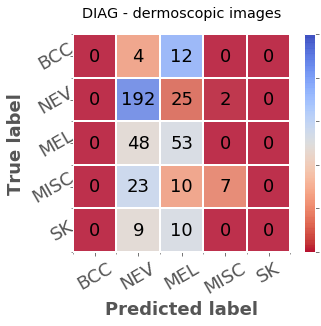

Accuracy Score: 63.79746835443038 %
Cross-Validation Score: 60.614384366735244 %


In [78]:
# Display a confusion matrix.
plot_confusion(y_true=test_labels[abbrev], y_pred=pred, labels=label_names, figsize=(6,4))
plt.title(abbrev + ' - dermoscopic images')
plt.show()
print("Accuracy Score:",temp*100,"%")
print("Cross-Validation Score:",score*100,"%")

In [46]:
# Gaussian Process Classifier
reg = GaussianProcessClassifier(1.0 * RBF(1.0))
reg.fit(train_derm_f, train_labels[abbrev])
reg.fit(valid_derm_f, valid_labels[abbrev])  
# cross validation.
scores_t = cross_val_score(reg, train_derm_f, train_labels[abbrev], cv=5, scoring='accuracy')
scores_l = cross_val_score(reg, valid_derm_f, valid_labels[abbrev], cv=5, scoring='accuracy')
t1 = scores_t.mean()
t2 = scores_l.mean()
score = (t1+t2)/2
#prediciton
pred = reg.predict(test_derm_f)
temp = accuracy_score(test_labels[abbrev],pred)

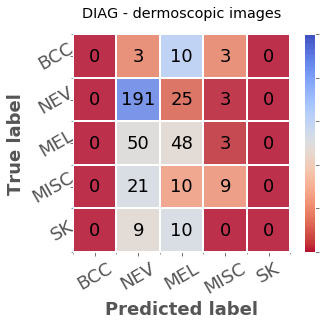

Accuracy Score: 62.78481012658228 %
Cross-Validation Score: 59.61879224213929 %


In [47]:
# Display a confusion matrix.
plot_confusion(y_true=test_labels[abbrev], y_pred=pred, labels=label_names, figsize=(6,4))
plt.title(abbrev + ' - dermoscopic images')
plt.show()
print("Accuracy Score:",temp*100,"%")
print("Cross-Validation Score:",score*100,"%")

In [39]:
# Gaussian Naive Bayes Classifier
reg = GaussianNB()
reg.fit(train_derm_f, train_labels[abbrev])
reg.fit(valid_derm_f, valid_labels[abbrev])  
# cross validation.
scores_t = cross_val_score(reg, train_derm_f, train_labels[abbrev], cv=5, scoring='accuracy')
scores_l = cross_val_score(reg, valid_derm_f, valid_labels[abbrev], cv=5, scoring='accuracy')
t1 = scores_t.mean()
t2 = scores_l.mean()
score = (t1+t2)/2

#prediciton
pred = reg.predict(test_derm_f)
temp = accuracy_score(test_labels[abbrev],pred)

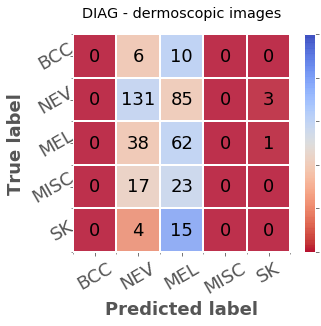

Accuracy Score: 48.860759493670884 %
Cross-Validation Score: 46.120408463120775 %


In [43]:
# Display a confusion matrix.
plot_confusion(y_true=test_labels[abbrev], y_pred=pred, labels=label_names, figsize=(6,4))
plt.title(abbrev + ' - dermoscopic images')
plt.show()
print("Accuracy Score:",temp*100,"%")
print("Cross-Validation Score:",score*100,"%")